In [156]:
import pandas as pd
import numpy as np

### Objective
The goal is to investigate whether or not there is a "home field advantage" for a nation that hosts the Olympic games. This analysis will study the Chinese olympic team, and try to determine if there was an unusually high improvement in performance during the 2008 Summer Olympic Games in Beijing.

### Metrics to Produce
We will look at the following metrics in order to check for a host advantage, considering medal count as the measure for success in an Olympic Games:
- Medal count trends:
    - Did the total medal count increase during the hosted olympics?
    - How many standard deviations (z-score) from the average medal count across all olympic games was the medal count for the hosted games?
    - Where did the host country place on the total medal rankings in their hosted games vs. other games?
    - How did the host country's performance metrics compare to the rest of the world's metrics? Does that tell us anything?


In [157]:
# load the csv file for analysis
df = pd.read_csv('resources/athlete_events.csv')

In [158]:
# We want to make sure that there are no duplicate event medals, for example,
# if NOC == ARG won a gold medal in Men's Football in 2004, we want to make sure
# that only 1 gold medal is counted (instead of 1 for every player on the team),
# so we will drop duplicates based on the columns 'Year', 'Event', 'Medal', 'NOC'

no_team_medals_df = df.drop_duplicates(subset=['Year', 'Event', 'Medal', 'NOC'])

In [159]:
# use only the Summer Olympics for Analysis
summer_df = no_team_medals_df[no_team_medals_df['Season'] == 'Summer']

In [160]:
# create a dataframe for only the Chinese team, where "China" is anywhere in the team name
china_df = summer_df[summer_df['Team'].str.contains('China')]
# print the unique values of Team column to see if they are all "China"
print(china_df['Team'].unique())
print(china_df['NOC'].unique())
# Clean up the Team column to have only "China" instead of "China-1", "China-2", etc.
china_df.loc[:, 'Team'] = 'China'
print(china_df['Team'].unique())

# It looks like NOC is a more accurate way to describe the country's team,
# and doesn't pose as many issues as the Team column does (e.g. "China-1", "China-2", etc.)
# Let's use NOC instead of Team for the rest of the analysis.
china_df = summer_df[summer_df['NOC'] == 'CHN']

['China' 'China-2' 'China-1' 'China-3']
['CHN']
['China']


In [161]:
# create a dataframe where NOC is not CHN
rest_of_world_df = summer_df[summer_df['NOC'] != 'CHN']

# Clean up the team names to have only the country name
# if "-" appears in the team name, use only the part of the string that comes before "-"
rest_of_world_df.loc[:, 'Team'] = rest_of_world_df['Team'].str.split('-').str[0]


In [162]:
# create a dataframe for the Chinese team in the Summer Olympics grouped by Games. 
games_df_china = china_df.groupby('Games').agg({'Medal': 'count'})

# Add columns for gold_medals, silver_medals, bronze_medals and total_medals
games_df_china['gold_medals'] = china_df[china_df['Medal'] == 'Gold'].groupby('Games').agg({'Medal': ['count']})
games_df_china['silver_medals'] = china_df[china_df['Medal'] == 'Silver'].groupby('Games').agg({'Medal': ['count']})
games_df_china['bronze_medals'] = china_df[china_df['Medal'] == 'Bronze'].groupby('Games').agg({'Medal': ['count']})

# fill NaN values with 0
games_df_china = games_df_china.fillna(0)

# format values in all columns except Games to integers
games_df_china = games_df_china.astype(int)

games_df_china

,Medal,gold_medals,silver_medals,bronze_medals
Games,,,,
1932 Summer,0,0,0,0
1936 Summer,0,0,0,0
1948 Summer,0,0,0,0
1952 Summer,0,0,0,0
1984 Summer,32,15,8,9
1988 Summer,28,5,11,12
1992 Summer,53,16,22,15
1996 Summer,50,16,22,12
2000 Summer,58,28,16,14


In [163]:
# create a cleaner "total_medals" column
games_df_china['total_medals'] = games_df_china[['gold_medals', 'silver_medals', 'bronze_medals']].sum(axis=1)

# Add a column for non-medal participations, which is the count of all rows for Games where Medal is NaN
games_df_china['non_medal_participations'] = china_df[china_df['Medal'].isnull()].groupby('Games').size()

# Add a column for total participations, which is the count of all rows for Games.
# This includes 0 or NaN values for medals
games_df_china['total_participations'] = china_df.groupby('Games').size()
games_df_china

,Medal,gold_medals,silver_medals,bronze_medals,total_medals,non_medal_participations,total_participations
Games,,,,,,,
1932 Summer,0,0,0,0,0,2,2
1936 Summer,0,0,0,0,0,27,27
1948 Summer,0,0,0,0,0,12,12
1952 Summer,0,0,0,0,0,1,1
1984 Summer,32,15,8,9,32,96,128
1988 Summer,28,5,11,12,28,142,170
1992 Summer,53,16,22,15,53,127,180
1996 Summer,50,16,22,12,50,141,191
2000 Summer,58,28,16,14,58,136,194


In [164]:
# Create a column called 'medal_rate' which is the ratio of medal count to total participation count
games_df_china['medal_rate'] = games_df_china['total_medals'] / games_df_china['total_participations']
games_df_china

,Medal,gold_medals,silver_medals,bronze_medals,total_medals,non_medal_participations,total_participations,medal_rate
Games,,,,,,,,
1932 Summer,0,0,0,0,0,2,2,0.000000
1936 Summer,0,0,0,0,0,27,27,0.000000
1948 Summer,0,0,0,0,0,12,12,0.000000
1952 Summer,0,0,0,0,0,1,1,0.000000
1984 Summer,32,15,8,9,32,96,128,0.250000
1988 Summer,28,5,11,12,28,142,170,0.164706
1992 Summer,53,16,22,15,53,127,180,0.294444
1996 Summer,50,16,22,12,50,141,191,0.261780
2000 Summer,58,28,16,14,58,136,194,0.298969


In [165]:
# create columns called gold_percentage, silver_percentage, bronze_percentage and non_medal_percentage
games_df_china['gold_percentage'] = games_df_china['gold_medals'] / games_df_china['total_medals']
games_df_china['silver_percentage'] = games_df_china['silver_medals'] / games_df_china['total_medals']
games_df_china['bronze_percentage'] = games_df_china['bronze_medals'] / games_df_china['total_medals']
games_df_china['non_medal_percentage'] = games_df_china['non_medal_participations'] / games_df_china['total_participations']

games_df_china

,Medal,gold_medals,silver_medals,bronze_medals,total_medals,non_medal_participations,total_participations,medal_rate,gold_percentage,silver_percentage,bronze_percentage,non_medal_percentage
Games,,,,,,,,,,,,
1932 Summer,0,0,0,0,0,2,2,0.000000,NaN,NaN,NaN,1.000000
1936 Summer,0,0,0,0,0,27,27,0.000000,NaN,NaN,NaN,1.000000
1948 Summer,0,0,0,0,0,12,12,0.000000,NaN,NaN,NaN,1.000000
1952 Summer,0,0,0,0,0,1,1,0.000000,NaN,NaN,NaN,1.000000
1984 Summer,32,15,8,9,32,96,128,0.250000,0.468750,0.250000,0.281250,0.750000
1988 Summer,28,5,11,12,28,142,170,0.164706,0.178571,0.392857,0.428571,0.835294
1992 Summer,53,16,22,15,53,127,180,0.294444,0.301887,0.415094,0.283019,0.705556
1996 Summer,50,16,22,12,50,141,191,0.261780,0.320000,0.440000,0.240000,0.738220
2000 Summer,58,28,16,14,58,136,194,0.298969,0.482759,0.275862,0.241379,0.701031


<Axes: title={'center': 'Medals Won by China in the Summer Olympics'}, xlabel='Games'>

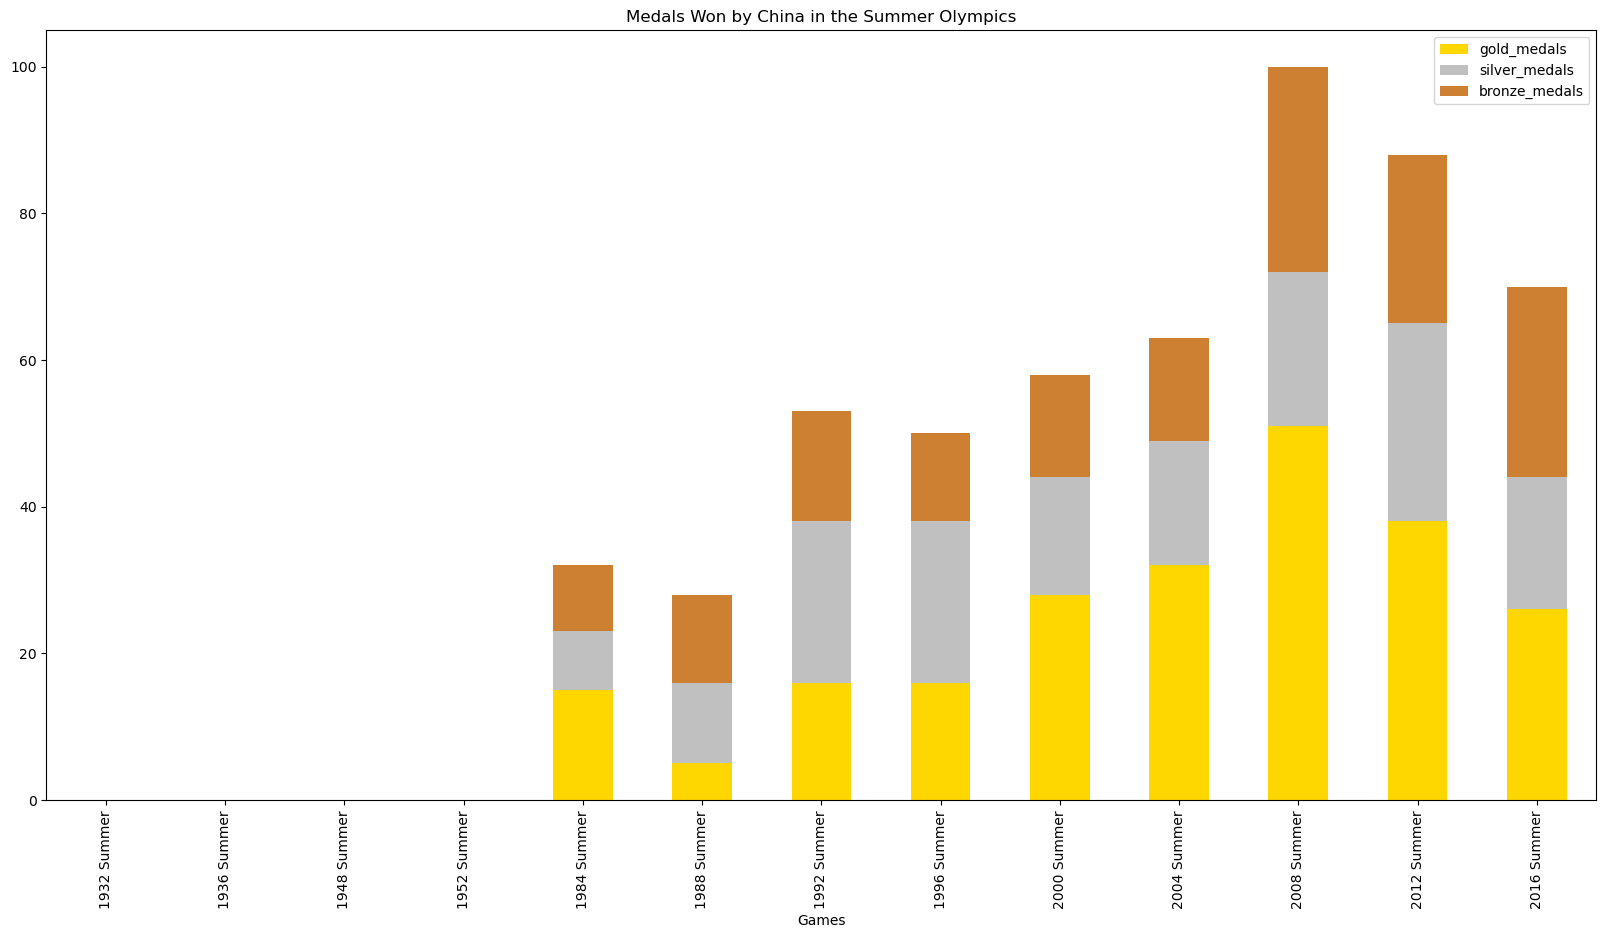

In [166]:
# Plot the gold_medals, silver_medals, bronze_medals and non_medal_participations for the Chinese team in the Summer Olympics.
# Use a stacked bar chart, where the total size of the bar is the total_participations

import matplotlib.pyplot as plt
games_df_china[['gold_medals', 'silver_medals', 'bronze_medals']].plot(
                                    kind='bar',
                                    stacked=True,
                                    figsize=(20, 10),
                                    color=['#ffd700', '#c0c0c0', '#cd7f32'],
                                    title='Medals Won by China in the Summer Olympics',)
# use #ffd700 for gold, #c0c0c0 for silver and #cd7f32 for bronze



<Axes: title={'center': 'Medal Rate for China in the Summer Olympics'}, xlabel='Games'>

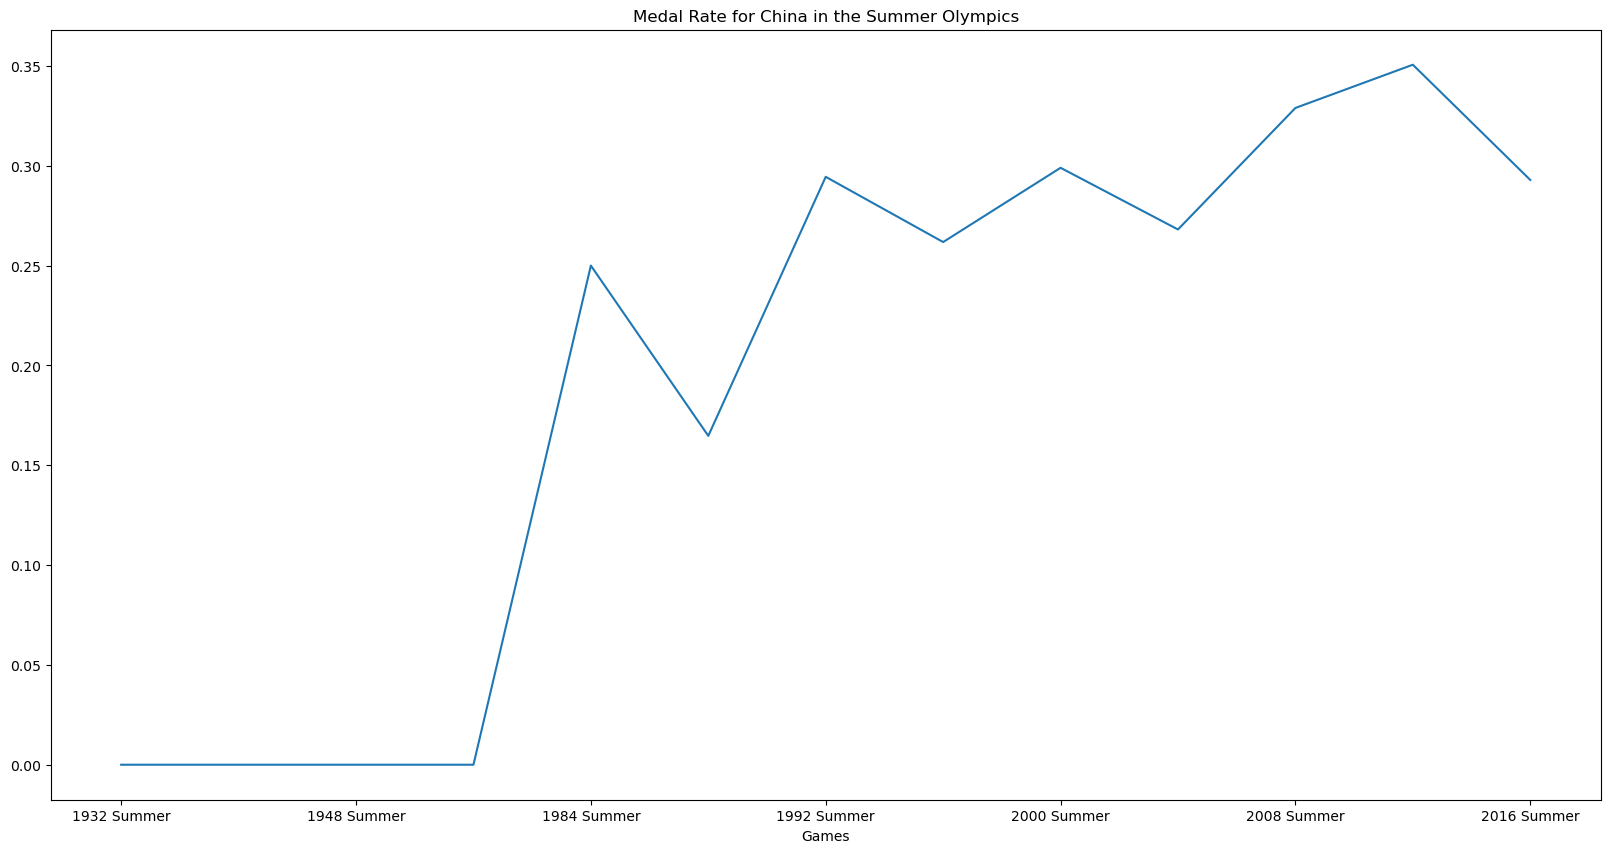

In [167]:
# Use a line chart to plot the medal_rate for the Chinese team in the Summer Olympics.
games_df_china['medal_rate'].plot(kind='line', figsize=(20, 10), title='Medal Rate for China in the Summer Olympics')

<Axes: xlabel='Games'>

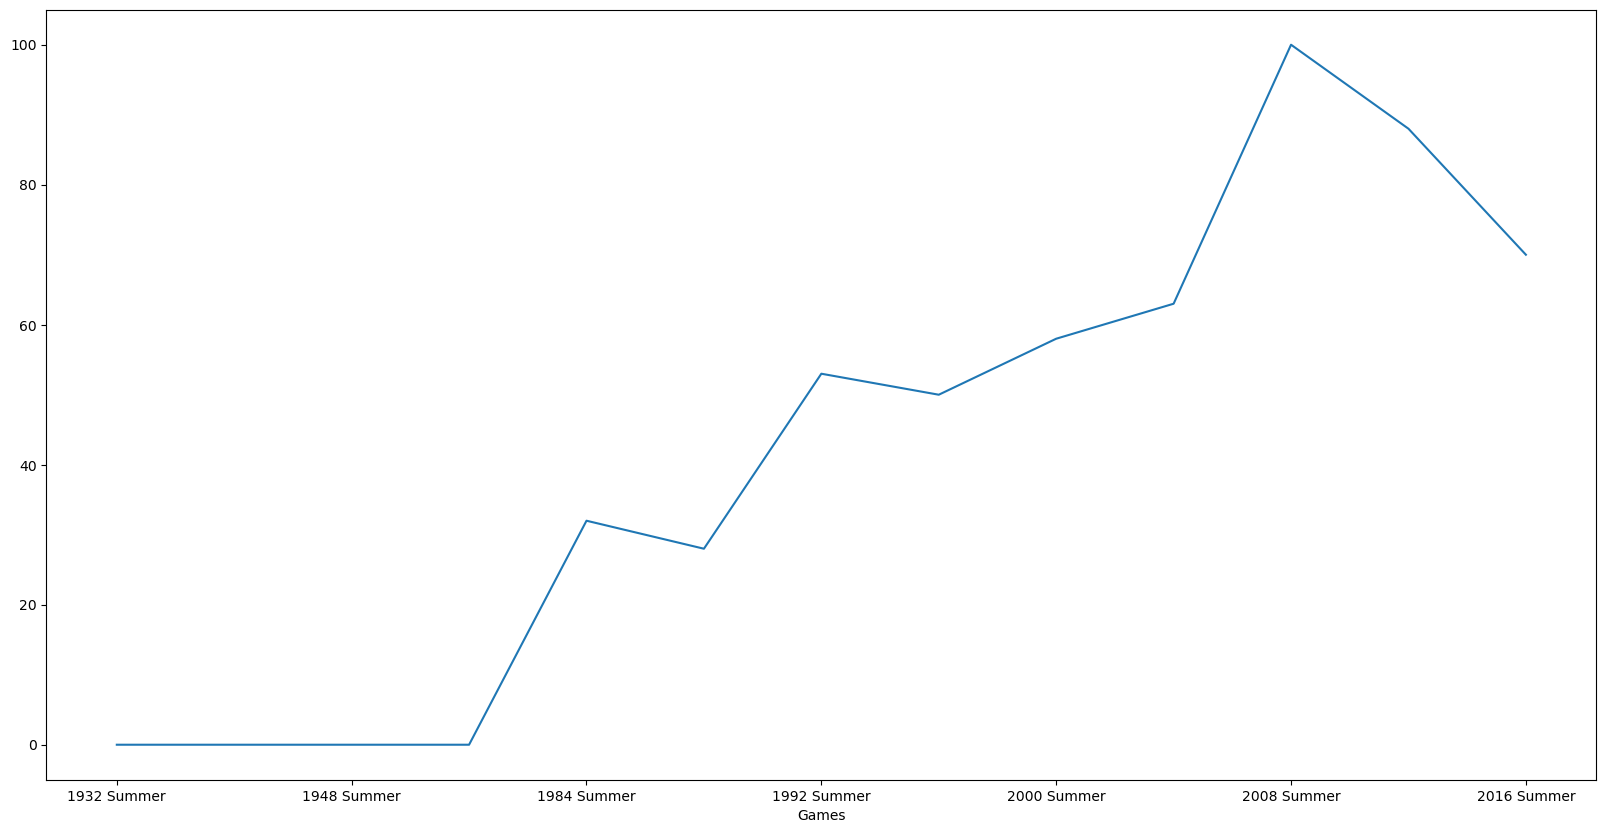

In [177]:
# Use a line chart to plot the medal count for the Chinese team in the Summer Olympics.
games_df_china['total_medals'].plot(kind='line', figsize=(20, 10))



In [178]:
# Calculate the average medal count for the Chinese team for the summer olympics
average_medal_count_china = games_df_china['total_medals'].mean()
print(average_medal_count_china)

# Calculate the average medal count for the Chinese team in the games where they won at least one medal
average_medal_count_china_won = games_df_china[games_df_china['total_medals'] > 0]['total_medals'].mean()
print(average_medal_count_china_won)

41.69230769230769
60.22222222222222


In [179]:
# Calculate the standard deviation of the medal count for the Chinese team for the summer olympics
std_dev_medal_count_china = games_df_china['total_medals'].std()
print(std_dev_medal_count_china)

# Calculate the standard deviation of the medal count for the Chinese team in the games where they won at least one medal
# This is just for the sake of comparison.
std_dev_medal_count_china_won = games_df_china[games_df_china['total_medals'] > 0]['total_medals'].std()
print(std_dev_medal_count_china_won)

34.75721655374755
23.594373152182797


In [180]:
# Show the medal count for the 2008 Summer Games
games_df_china.loc['2008 Summer'] 

Medal                       100.000000
gold_medals                  51.000000
silver_medals                21.000000
bronze_medals                28.000000
total_medals                100.000000
non_medal_participations    204.000000
total_participations        304.000000
medal_rate                    0.328947
gold_percentage               0.510000
silver_percentage             0.210000
bronze_percentage             0.280000
non_medal_percentage          0.671053
z_scores                      1.746071
Name: 2008 Summer, dtype: float64

In [181]:
from scipy.stats import zscore

# add z_scores column to the games_df_china dataframe
games_df_china['z_scores'] = zscore(games_df_china['total_medals'])
games_df_china

,Medal,gold_medals,silver_medals,bronze_medals,total_medals,non_medal_participations,total_participations,medal_rate,gold_percentage,silver_percentage,bronze_percentage,non_medal_percentage,z_scores
Games,,,,,,,,,,,,,
1932 Summer,0,0,0,0,0,2,2,0.000000,NaN,NaN,NaN,1.000000,-1.248510
1936 Summer,0,0,0,0,0,27,27,0.000000,NaN,NaN,NaN,1.000000,-1.248510
1948 Summer,0,0,0,0,0,12,12,0.000000,NaN,NaN,NaN,1.000000,-1.248510
1952 Summer,0,0,0,0,0,1,1,0.000000,NaN,NaN,NaN,1.000000,-1.248510
1984 Summer,32,15,8,9,32,96,128,0.250000,0.468750,0.250000,0.281250,0.750000,-0.290244
1988 Summer,28,5,11,12,28,142,170,0.164706,0.178571,0.392857,0.428571,0.835294,-0.410027
1992 Summer,53,16,22,15,53,127,180,0.294444,0.301887,0.415094,0.283019,0.705556,0.338618
1996 Summer,50,16,22,12,50,141,191,0.261780,0.320000,0.440000,0.240000,0.738220,0.248781
2000 Summer,58,28,16,14,58,136,194,0.298969,0.482759,0.275862,0.241379,0.701031,0.488347


The above distribution shows us visually that the Chinese team's medal haul in the 2008 games is much higher than the mean, and that they had their early efforts of 0 medals won skewed the data a bit.

In [182]:
# Calculate the mean total_medals for the Chinese team in all Games except for Beijing 2008
mean_total_medals_china = games_df_china[games_df_china.index != '2008 Summer']['total_medals'].mean()
print(mean_total_medals_china)

# Calculate the mean total_medals for the Chinese team including Beijing 2008
mean_total_medals_china_all = games_df_china['total_medals'].mean()
print(mean_total_medals_china_all)

# Calculate the z-score of the total_medals for the Chinese team in all Games except for Beijing 2008
z_score_total_medals_china = zscore(games_df_china[games_df_china.index != '2008 Summer']['total_medals'])
print(z_score_total_medals_china)

36.833333333333336
41.69230769230769
Games
1932 Summer   -1.227002
1936 Summer   -1.227002
1948 Summer   -1.227002
1952 Summer   -1.227002
1984 Summer   -0.161009
1988 Summer   -0.294258
1992 Summer    0.538548
1996 Summer    0.438611
2000 Summer    0.705110
2004 Summer    0.871671
2012 Summer    1.704477
2016 Summer    1.104857
Name: total_medals, dtype: float64


In [174]:
# Using our rest_of_world_df dataframe, let's get the 2008 Summer Games data
summer_2008_rw = rest_of_world_df[rest_of_world_df['Games'] == '2008 Summer']

# group this df by NON and calculate the total medals won in a new column called total_medals
summer_2008_rw = summer_2008_rw.groupby('NOC').agg({'Medal': 'count'})

# order the medal column by descending medal count
summer_2008_rw = summer_2008_rw.sort_values(by='Medal', ascending=False)

summer_2008_rw.head()


,Medal
NOC,
USA,110
RUS,72
GBR,48
AUS,46
FRA,41


With 100 medals, China would have come in 2nd in the medal rankings. 

In [175]:
# Let's calculate the average medal count for the rest of the world in the 2008 Summer Olympics
average_medal_count_rw_2008 = summer_2008_rw['Medal'].mean()
average_medal_count_rw_2008

4.221674876847291

Summary for Team China

| Metric                        | 2008 Beijing (Chinese Team) | Other Games  (Chinese Team)       |
|-------------------------------|-----------------------------|-----------------------------------|
| Medal Count                   | 100                         | 41.69 (mean)                      |
| z-score                       | 1.74                        | (next best 3) 1.38, 0.84, 0.64    |
| Medal Ranking for Games       | 2                           |                                   |


As we can see graphically above, the Chinese team shows a significant increase in medal count for the 2008 games. They were trending up after starting out without winning a medal in their first few Olympic participations. This performance was ~1.75 standard deviations from the mean, followed by a drop to a z-score of about 1.38.

Although they had the most medals, it looks as if their medal rate (success rate) was higher in the 2012 Games. They didn't have as many medals in 2012, but definitely had a higher rate of athletes winning a medal in those Games.

Overall, it's clear that the Chinese team had their best performance of all time in 2008. It's difficult to drill down into the factors that lead to a host advantage ($ spent on training and facilities, cultural changes to value the olympics, etc.), but we can safely conclude that, quantifiable or not, there was a major boost to the Chinese team given that they were the host nation.


